In [1]:
import face_recognition as fr
from skimage import feature
import numpy as np
import time
import cv2
import os

TARGET_SIZE = (128, 128)

def calc_hist(img):
    histogram = [0] * 3
    for j in range(3):
        histr = cv2.calcHist([img], [j], None, [256], [0, 256])
        histr *= 255.0 / histr.max()
        histogram[j] = histr
    return np.array(histogram)

def extract_features(img):
    # resize to TARGET_SIZE
    # to use with face_recognition faster
    # img = cv2.resize(img, TARGET_SIZE)
    try:
        face_bounding_boxes = fr.face_locations(img)
        # If detecting image contains exactly one face
        if len(face_bounding_boxes) == 1:
            feature_vector = fr.face_encodings(img, face_bounding_boxes)

            # top, right, bottom, left = face_bounding_boxes[0]
            # roi = img[top:bottom, left:right]
            # img_ycrcb = cv2.cvtColor(roi, cv2.COLOR_BGR2YCR_CB)
            # img_luv = cv2.cvtColor(roi, cv2.COLOR_BGR2LUV)

            # ycrcb_hist = calc_hist(img_ycrcb)
            # luv_hist = calc_hist(img_luv)
            # feature_vector = np.append(ycrcb_hist.ravel(), luv_hist.ravel())
            # feature_vector = feature_vector.reshape(1, len(feature_vector))
            
            # feature_vector = LBP(img, 24, 8)

            return feature_vector
        else:
            return []
    except:
        return []

def valid(name):
    return name != '.DS_Store' and name != 'Icon\r'

def load_dataset(pathname):
    X, y = [], []
    for label in sorted(os.listdir(pathname)):
        if valid(label):
            print(label + ' in processing...')
            path_img = os.path.join(pathname, label)
            for img in os.listdir(path_img):
                if valid(img):
                    img = cv2.imread(os.path.join(path_img, img))
                    features = extract_features(img)
                    # print(features)
                    if len(features) == 1:
                        X.append(features[0])
                        y.append(label)

    return np.array(X), np.array(y)


X, y = load_dataset('faces')

phuc in processing...
thao in processing...
tinh in processing...
unknown in processing...


In [2]:
X.shape

(1266, 128)

In [3]:
s_acc = s_loss = 0
def scorer(model, X_test, y_test):
    global s_acc, s_loss
    y_pred = model.predict(X_test)
    s_acc += accuracy_score(y_test, y_pred)

    y_pred = model.predict_proba(X_test)
    s_loss += log_loss(y_test, y_pred)
    return s_acc

def score_dataset(dataset_name, model, X, y, cv=None):
    global s_acc, s_loss
    if cv:
        s_acc = s_loss = 0
        scores = cross_val_score(model, X, y, cv=cv, scoring=scorer)
        mean_acc = s_acc/cv
        mean_loss = s_loss/cv
        print("%12s %2d-folds = %.3f with loss = %.3f" % (dataset_name, cv, mean_acc, mean_loss))
        return mean_acc, mean_loss
    else:
        for nFold in range(2, 10+1):
            scores = cross_val_score(model, X, y, cv=nFold)
            print("%s %2d-folds = %.3f" % (dataset_name, nFold, np.mean(scores)))

In [14]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn import svm
from sklearn.metrics import accuracy_score, log_loss
import pandas as pd
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

models = {
    'kNN': KNeighborsClassifier(8),
    'GaussianNB': GaussianNB(),
    'DecisionTree': tree.DecisionTreeClassifier(criterion="gini"),
    'Bagging': BaggingClassifier(base_estimator=tree.DecisionTreeClassifier(), n_estimators=100),
    'AdaBoost': AdaBoostClassifier(base_estimator=tree.DecisionTreeClassifier(max_depth=2), n_estimators=50),
    'RandomForest': RandomForestClassifier(n_estimators=50),
    # 'NuSVC': svm.NuSVC(probability=True),
    'SVM_Linear': svm.SVC(kernel='linear', C=1000, probability=True),
    'SVM_Poly': svm.SVC(kernel='poly', C=100000, probability=True), # 100000
    'SVM_RBF': svm.SVC(kernel='rbf', C=100000, gamma=0.01, probability=True),
    'SVM_Sigmoid': svm.SVC(kernel='sigmoid', C=100000, gamma=0.0001, probability=True)
}

# Logging for Visual Comparison
log_cols=["Classifier", "Accuracy", "Log Loss"]
log = pd.DataFrame(columns=log_cols)

for model in models.items():
    mean_acc, mean_loss = score_dataset(model[0], model[1], X, y, cv=10)
    log_entry = pd.DataFrame([[model[0], mean_acc*100, mean_loss]], columns=log_cols)
    log = log.append(log_entry)

         kNN 10-folds = 0.998 with loss = 0.003
  GaussianNB 10-folds = 0.995 with loss = 0.120
DecisionTree 10-folds = 0.991 with loss = 0.327
     Bagging 10-folds = 0.998 with loss = 0.019
    AdaBoost 10-folds = 0.951 with loss = 0.106
RandomForest 10-folds = 1.000 with loss = 0.025
  SVM_Linear 10-folds = 1.000 with loss = 0.009
    SVM_Poly 10-folds = 1.000 with loss = 0.009
     SVM_RBF 10-folds = 1.000 with loss = 0.009
 SVM_Sigmoid 10-folds = 1.000 with loss = 0.009


In [15]:

result = 'results/' + time.strftime('%Y%m%d_%H%M%S')
os.mkdir(result)
print(log)
log.to_csv(result + '/log.csv', index=False)

     Classifier    Accuracy  Log Loss
0           kNN   99.842520  0.002687
0    GaussianNB   99.526309  0.119894
0  DecisionTree   99.053243  0.326998
0       Bagging   99.763780  0.019008
0      AdaBoost   95.079365  0.106090
0  RandomForest  100.000000  0.024828
0    SVM_Linear  100.000000  0.008948
0      SVM_Poly  100.000000  0.008927
0       SVM_RBF  100.000000  0.008915
0   SVM_Sigmoid  100.000000  0.008945


Text(0.5, 1.0, 'Classifier Log Loss')

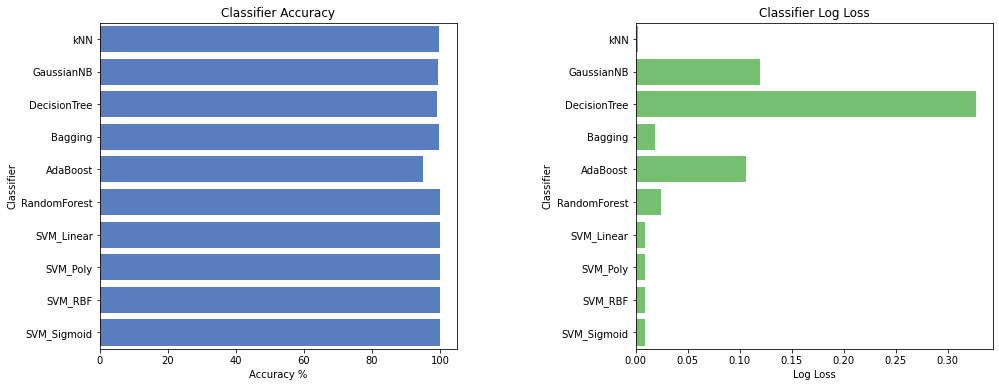

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (16, 6)
plt.subplots_adjust(wspace=0.5)

plt.subplot(1, 2, 1)
sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")

plt.xlabel('Accuracy %')
plt.title('Classifier Accuracy')
# plt.show()

plt.subplot(1, 2, 2)
sns.set_color_codes("muted")
sns.barplot(x='Log Loss', y='Classifier', data=log, color="g")

plt.xlabel('Log Loss')
plt.title('Classifier Log Loss')
# plt.show()


plt.savefig(result + '/figure.png' )

In [17]:
from sklearn.model_selection import train_test_split
from joblib import dump

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=3./10, random_state=2020)
clf = svm.SVC(kernel='rbf', C=100000, gamma=0.01, probability=True)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(acc)
dump(clf, result+ '/faces.model')

1.0


['faces2.model']